In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mysql.connector
import pandas as pd
import numpy as np

import mysql.connector
import pandas as pd

# MySQL 연결 설정
cnx = mysql.connector.connect(
    host='',
    user='',
    password='',
    database=''
)

# 쿼리 생성
query_ball = "SELECT * FROM ball_df"
query_sequence_df = "SELECT * FROM sequence_df"
query_events_df = "SELECT * FROM events_df"

# DataFrame으로 읽기
ball_df = pd.read_sql(query_ball, con=cnx)
sequence_df = pd.read_sql(query_sequence_df, con=cnx)
events_df = pd.read_sql(query_events_df, con=cnx)

# 연결 종료 (선택적)
cnx.close()

카메라 각도에서의 공의 x,y좌표들을 위에서 바라본 시점에서의 좌표료 변환하기 위해 Homography Matrix을 활용하여 여러 시도를 했었지만 그렇게 해서 나타낸 시각화 결과가 모두 엉망이었습니다.\
\
하지만 bounce 지점만큼은 변환된 좌표값의 결과가 나름 양호했습니다.\
\
Homography Matrix의 경우 테이블 좌표를 위에서 바라본 시점의 실제 탁구 테이블 크기의 좌표로 변환하였으며 bounce 이벤트의 경우 테이블 바로 위에서 일어난 2D에 해당한 이벤트이기 때문에 좌표를 변환해도 bounce 지점만큼은 결과가 양호했단 것으로 추측이 가능합니다.

이렇게 Homography Matrix를 통해 좌표를 위에서 바라본 시점으로 변환한 값 중에서 bounce 좌표들만 활용하여 분석에 활용하겠습니다.

In [3]:
import cv2
import pandas as pd
import numpy as np

# 탁구 동영상의 카메라 시점에서의 탁구 테이블 꼭지점 좌표
camera_points = np.float32([[305, 103], [510, 217], [1297, 202], [1435, 76]])

# 위의 테이블 꼭지점 좌표를 변환할 실제 탁구대 수직 방향에서의 좌표 (가로 2740mm, 세로 1525mm)
real_world_points = np.float32([[0, 0], [0, 1525], [2740, 1525], [2740, 0]])

# 원근에 대한 변환 행렬 계산
perspective_transform_matrix = cv2.getPerspectiveTransform(camera_points, real_world_points)

# ball_df의 각 좌표에 원근 변환을 적용
transformed_points = cv2.perspectiveTransform(np.array([ball_df[['x', 'y']].values], dtype='float32'), perspective_transform_matrix)[0]

# 변환된 좌표로 새 데이터 프레임 생성
transformed_df = pd.DataFrame(transformed_points, columns=['x_transformed', 'y_transformed'])
transformed_df['frame'] = ball_df['frame']  # ball_df에서 참조용 프레임 번호 포함

# ball_df에서 변환된 좌표로 변형
ball_df[['x', 'y']] = transformed_df[['x_transformed','y_transformed']]

# 정수로 변경
ball_df[['x', 'y']] = ball_df[['x', 'y']].round().astype('Int64')

ball_df = ball_df.drop(columns='index')

ball_df.head()

,sequence,frame,x,y,player
0,1,15,57,1493,player_A
1,1,16,134,1408,player_A
2,1,17,222,1293,player_A
3,1,18,283,1248,player_A
4,1,19,299,1335,player_A


In [4]:
# mysql에서 불러올 때 자동으로 생성되는 열 제거
events_df = events_df.drop(columns='index')
events_df.head()

,frame,x,y,event,player
0,18,566,200,bounce,player_A
1,33,897,228,net,player_A
2,44,500,138,bounce,player_A
3,2192,1305,110,bounce,player_B
4,2211,889,240,net,player_B


In [5]:
# ball_df의 변환된 행렬을 events_df에 병합
merged_df = pd.merge(events_df, ball_df[['frame', 'x', 'y']], on='frame', how='left')

events_df['x'] = merged_df['x_y']
events_df['y'] = merged_df['y_y']

events_df.head()

,frame,x,y,event,player
0,18,283,1248,bounce,player_A
1,33,1346,1883,net,player_A
2,44,355,393,bounce,player_A
3,2192,2500,289,bounce,player_B
4,2211,1298,2143,net,player_B


이렇게 변환된 좌표에서 추출한 bounce 이벤트 지점들의 결과가 어떤지 시각화로 확인합니다.

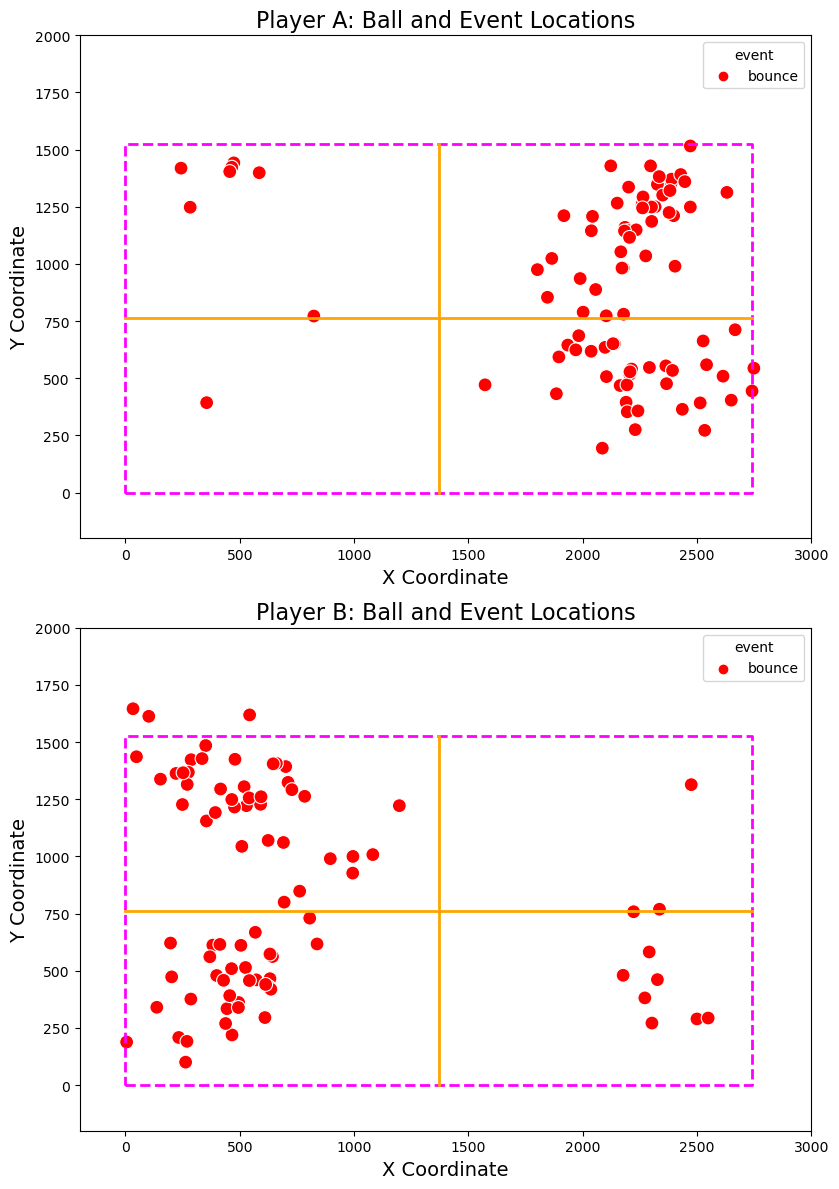

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 이벤트의 색상 및 마커 설정
bounce_colors = {'bounce': 'red'}
bounce_markers = {'bounce': 'o'}  

# 테이블과 네트선, 라인선을 그리기 위한 좌표
rectangle_coords = [(0, 0), (2740, 0), (2740, 1525), (0, 1525), (0, 0)]  # 사각형 좌표 (시작점으로 돌아감)
line_coords_1 = [(1370, 0), (1370, 1525)]  # 네트선
line_coords_2 = [(0, 762.5), (2740, 762.5)]  # 라인선

# 플레이어 별로 구분해서 보여주기 위한 subplot 설정
fig, axes = plt.subplots(2, 1, figsize=(12, 12))


for ax in axes:
    # 테이블 그리기
    ax.plot(*zip(*rectangle_coords), color='magenta', linestyle='--', linewidth=2)  # 사각형
    # 두 선 연결
    ax.plot(*zip(*line_coords_1), color='orange', linestyle='-', linewidth=2)  # 네트선
    ax.plot(*zip(*line_coords_2), color='orange', linestyle='-', linewidth=2)  # 라인선


# Player A
sns.scatterplot(data=events_df[events_df['player'] == 'player_A'][events_df['event'] == 'bounce'], 
                x='x', y='y', hue='event', style='event',
                ax=axes[0], palette=bounce_colors, markers=bounce_markers, s=100, legend='full')


axes[0].set_title('Player A: Ball and Event Locations', fontsize=16)
axes[0].set_xlabel('X Coordinate', fontsize=14)
axes[0].set_ylabel('Y Coordinate', fontsize=14)

axes[0].set_xlim(-200, 3000)
axes[0].set_ylim(-200, 2000)

# Player B
sns.scatterplot(data=events_df[events_df['player'] == 'player_B'][events_df['event'] == 'bounce'], 
                x='x', y='y', hue='event', style='event',
                ax=axes[1], palette=bounce_colors, markers=bounce_markers, s=100, legend='full')


axes[1].set_title('Player B: Ball and Event Locations', fontsize=16)
axes[1].set_xlabel('X Coordinate', fontsize=14)
axes[1].set_ylabel('Y Coordinate', fontsize=14)

axes[1].set_xlim(-200, 3000)
axes[1].set_ylim(-200, 2000)

# Player A와 Player B 축의 aspect ratio를 'equal'로 설정 (찌그러짐 방지)
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()


해당 결과는 앞서서 진행한 좌표 변환 전 bounce 발생 지점들과 비교하면 대체적으로 정확한 것으로 판단됩니다.\
\
테이블 바깥에서 발생했는데도 bounce라 표시된 지점이 표시된 오차가 발생했지만 추후 진행할 라인선 기준 bounce 좌우 결정에는 영향을 주지 않으므로 무시합니다.

##### 이제 플레이어 별로 바운스가 된 지점이 테이블을 바라본 시점이서 우측/좌측을 구분하겠습니다.

In [7]:
# bounce만 걸러냄
events_df_bounce = events_df[events_df['event'] == 'bounce']
events_df_bounce.head()

,frame,x,y,event,player
0,18,283,1248,bounce,player_A
2,44,355,393,bounce,player_A
3,2192,2500,289,bounce,player_B
6,2287,2292,547,bounce,player_A
7,9243,2336,769,bounce,player_B


In [8]:
# 라인선을 기준으로 bounce 위치를 up/down으로 나눈다.
events_df_bounce['bounce'] = events_df_bounce['y'].apply(lambda y_val: 'up' if y_val >= 762.5 else 'down')

# up/down을 플레이어의 방향에 따라 right/left로 바꿔준다,
# player_A의 경우 왼쪽을 바라보므로 up -> right, down -> left
# player_B의 경우 왼쪽을 바라보므로 up -> left, down -> right
def update_bounce(row):
    if row['player'] == 'player_A':
        if row['bounce'] == 'up':
          return 'left'
        else:
          return 'right'
    elif row['player'] == 'player_B':
        if row['bounce'] == 'up':
          return 'right'
        else:
          return 'left'

# 전체 행에 대해 적용
events_df_bounce['bounce'] = events_df_bounce.apply(update_bounce, axis=1)
events_df_bounce.head()

,frame,x,y,event,player,bounce
0,18,283,1248,bounce,player_A,left
2,44,355,393,bounce,player_A,right
3,2192,2500,289,bounce,player_B,left
6,2287,2292,547,bounce,player_A,right
7,9243,2336,769,bounce,player_B,right


##### 추가적으로 **sequence_df**에 SUB이벤트와 Net에 hit 유무에 대한 column을 생성해줍니다.

In [9]:
# ball_df에 bounce열을 추가하고 0으로 채워넣음
ball_df['bounce'] = 0

# events_df의 frame열의 값과 같은 값을 가지는 ball_df의 frame열의 값의 행의 bounce값을 1로 바꾼다.
ball_df.loc[ball_df['frame'].isin(events_df_bounce['frame']), 'bounce'] = 1

ball_df.head()

,sequence,frame,x,y,player,bounce
0,1,15,57,1493,player_A,0
1,1,16,134,1408,player_A,0
2,1,17,222,1293,player_A,0
3,1,18,283,1248,player_A,1
4,1,19,299,1335,player_A,0


In [10]:
# 이렇게 바꿔준 ball_df의 bounce의 값이 1인 행에서 x값이 1370보다 크거나 같으면 bounce의 값을 left, x값이 1370보다 작으면 bounce의 값을 right로 바꾼다.
# (1370은 네트선의 x좌표이다.)

ball_df.loc[(ball_df['bounce'] == 1) & (ball_df['x'] >= 1370), 'bounce'] = 'left'
ball_df.loc[(ball_df['bounce'] == 1) & (ball_df['x'] < 1370), 'bounce'] = 'right'

ball_df.head()

,sequence,frame,x,y,player,bounce
0,1,15,57,1493,player_A,0
1,1,16,134,1408,player_A,0
2,1,17,222,1293,player_A,0
3,1,18,283,1248,player_A,right
4,1,19,299,1335,player_A,0


In [11]:
# 1이 남아있지 않음을 확인
ball_df['bounce'].unique()

array([0, 'right', 'left'], dtype=object)

In [12]:
# 이제 ball_df의 bounce가 0이 아닌 sequence에 대해 두 bounce값이 같으면 net_hit, 다르면 sub로 sequence_df에 추가한다.

# net_hit와 sub열을 생성하고 0으로 채움
sequence_df['net_hit'] = 0
sequence_df['sub'] = 0

# ball_df를 'sequence'로 그룹화하고 지정된 조건을 적용하여 sequence_df 업데이트
for seq, group in ball_df.groupby('sequence'):
    # 'bounce'가 0이 아닌 행 필터링
    bounces = group[group['bounce'] != 0]['bounce']

    if len(bounces) == 2:
        if bounces.nunique() == 1:  # 발생한 두 bounce의 좌우 방향이 동일 ex) right, right // left, left
            sequence_df.loc[sequence_df['sequence'] == seq, 'net_hit'] = 1
        elif bounces.nunique() == 2:  # 발생한 두 bounce의 좌우 방향이 다름 ex) right, left // rifht, left
            sequence_df.loc[sequence_df['sequence'] == seq, 'sub'] = 1

sequence_df.head()

,index,sequence,frame_1,frame_2,diff_frame,x1,y1,x2,y2,player,net_hit,sub
0,0,1,15,56,41,523,215,109,172,player_A,1,0
1,1,2,2189,2223,34,1407,124,704,254,player_B,0,0
2,2,3,2267,2299,32,848,262,1475,177,player_A,0,0
3,3,4,9240,9299,59,1269,163,612,244,player_B,0,1
4,4,5,9340,9369,29,874,254,1137,208,player_A,0,0


**sequence_df**에 추가적으로 sequence 별 공의 평균 속도를 계산해줍니다.\
\
속도는 2차원 상의 속도를 구합니다. (3차원은 해당 데이터만으로 방법x)

In [13]:
# 두 좌표 사이의 유클리드 거리를 계산하는 함수
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# 각 sequence에 대한 distance를 계산
sequence_df['distance'] = sequence_df.apply(lambda row: calculate_distance(row['x1'], row['y1'], row['x2'], row['y2']), axis=1)

# 공의 속도 계산(거리를 프레임 단위의 시간으로 나눈 값)
sequence_df['avg_velocity'] = sequence_df['distance'] / sequence_df['diff_frame']

# distance를 삭제
sequence_df = sequence_df.drop(columns='distance')

sequence_df['avg_velocity'] = sequence_df['avg_velocity'].round(2)

sequence_df.head()


,index,sequence,frame_1,frame_2,diff_frame,x1,y1,x2,y2,player,net_hit,sub,avg_velocity
0,0,1,15,56,41,523,215,109,172,player_A,1,0,10.15
1,1,2,2189,2223,34,1407,124,704,254,player_B,0,0,21.03
2,2,3,2267,2299,32,848,262,1475,177,player_A,0,0,19.77
3,3,4,9240,9299,59,1269,163,612,244,player_B,0,1,11.22
4,4,5,9340,9369,29,874,254,1137,208,player_A,0,0,9.21


In [14]:
# mysql로 보내기

from sqlalchemy import create_engine
 
db_connection_path = ''
db_connection = create_engine(db_connection_path)

conn = db_connection.connect()

events_df_bounce.to_sql('events_df_bounce', con = db_connection, if_exists= 'replace')
sequence_df.to_sql('sequence_df', con = db_connection, if_exists= 'replace')

160